# Comprehensive Binning Methods Comparison

This notebook provides a comprehensive demonstration and comparison of all binning methods available in the binlearn library. Each method is demonstrated with practical examples, visual comparisons, and guidance on when to use each approach.

## Methods Covered

### Unsupervised Methods:
- **EqualWidthBinning**: Divides range into equal-width intervals
- **EqualFrequencyBinning**: Creates bins with equal number of samples (quantile-based)
- **KMeansBinning**: Uses K-means clustering to determine bin boundaries
- **GaussianMixtureBinning**: Uses Gaussian Mixture Models for bin placement
- **DBSCANBinning**: Density-based clustering for irregular bin shapes
- **SingletonBinning**: Creates bins for unique values (good for discrete data)

### Supervised Methods (require target variable):
- **SupervisedBinning**: Decision tree-based optimal splits using target information
- **IsotonicBinning**: Monotonic binning based on target correlation
- **EqualWidthMinimumWeightBinning**: Equal width with minimum sample constraints

### Manual Methods:
- **ManualIntervalBinning**: User-defined bin boundaries
- **ManualFlexibleBinning**: Flexible manual bin specification

### Specialized Methods:
- **Chi2Binning**: Independence testing for categorical targets
- **DBSCANBinning**: Density-based clustering for irregular bin shapes

## Key Features Demonstrated:
- **Joint vs Per-Column Fitting** (where supported)
- **Input/Output Format Flexibility** (NumPy arrays, pandas DataFrames)
- **Sklearn Pipeline Integration**
- **Parameter Serialization and Reconstruction**
- **Clipping Behavior and Edge Cases**
- **Visual Comparisons and Performance Analysis**

## 1. Import Required Libraries

In [1]:
# Core libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import time
import warnings
warnings.filterwarnings('ignore')

# All binlearn methods
from binlearn.methods import (
    EqualWidthBinning,
    EqualFrequencyBinning, 
    KMeansBinning,
    GaussianMixtureBinning,
    DBSCANBinning,
    SingletonBinning,
    SupervisedBinning,
    IsotonicBinning,
    ManualIntervalBinning,
    EqualWidthMinimumWeightBinning,
    Chi2Binning
)

# Set styling
plt.style.use('default')
np.random.seed(42)

print("✅ All libraries and binning methods imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

✅ All libraries and binning methods imported successfully!
NumPy version: 2.3.2
Pandas version: 2.3.1
Matplotlib version: 3.10.5


## 2. Load and Prepare Sample Data

We'll create multiple datasets with different characteristics to test all binning methods:

In [2]:
# 1. Basic dataset for unsupervised methods
print("📊 Creating diverse datasets for comprehensive testing...")
n_samples = 300

# Mixed distribution dataset
data_mixed = pd.DataFrame({
    'normal': np.random.normal(50, 15, n_samples),
    'skewed': np.random.exponential(2, n_samples),
    'bimodal': np.concatenate([np.random.normal(20, 5, n_samples//2), 
                              np.random.normal(80, 5, n_samples//2)]),
    'uniform': np.random.uniform(0, 100, n_samples)
})

print(f"Mixed distribution dataset shape: {data_mixed.shape}")

# 2. Classification dataset for supervised methods
print("\n📊 Creating classification dataset for supervised methods...")
X_class, y_class = make_classification(
    n_samples=n_samples, 
    n_features=4, 
    n_informative=3,
    n_redundant=1,
    n_classes=3,
    random_state=42
)

# Convert to DataFrame for easier handling
data_supervised = pd.DataFrame(X_class, columns=['feature_1', 'feature_2', 'feature_3', 'feature_4'])
data_supervised['target'] = y_class

print(f"Supervised dataset shape: {data_supervised.shape}")
print(f"Target distribution: {np.bincount(y_class)}")

# 3. Discrete-heavy dataset for singleton binning
print("\n📊 Creating discrete dataset for singleton binning...")
data_discrete = pd.DataFrame({
    'discrete_low': np.random.choice([1, 2, 3, 4, 5], n_samples, p=[0.4, 0.25, 0.2, 0.1, 0.05]),
    'discrete_high': np.random.choice(range(1, 21), n_samples),
    'mixed_discrete': np.random.choice([10, 20, 30, 40, 50], n_samples//2).tolist() + 
                     np.random.normal(35, 10, n_samples//2).tolist()
})

print(f"Discrete dataset shape: {data_discrete.shape}")

# Display basic statistics
print("\n📈 Dataset Statistics:")
print("\nMixed distribution data:")
print(data_mixed.describe().round(2))
print("\nSupervised data features:")
print(data_supervised.iloc[:, :-1].describe().round(2))
print("\nDiscrete data:")
print(data_discrete.describe().round(2))

📊 Creating diverse datasets for comprehensive testing...
Mixed distribution dataset shape: (300, 4)

📊 Creating classification dataset for supervised methods...
Supervised dataset shape: (300, 5)
Target distribution: [102  99  99]

📊 Creating discrete dataset for singleton binning...
Discrete dataset shape: (300, 3)

📈 Dataset Statistics:

Mixed distribution data:
       normal  skewed  bimodal  uniform
count  300.00  300.00   300.00   300.00
mean    49.92    2.13    49.90    51.34
std     14.76    2.28    30.57    29.95
min      1.38    0.02     6.52     0.64
25%     39.75    0.55    19.81    23.31
50%     50.89    1.36    51.23    53.85
75%     59.40    2.94    80.21    77.23
max    107.79   16.34    93.16    99.79

Supervised data features:
       feature_1  feature_2  feature_3  feature_4
count     300.00     300.00     300.00     300.00
mean       -0.41      -0.07      -0.36       0.04
std         1.40       1.46       1.35       1.56
min        -3.88      -4.23      -4.34      -4

## 3. Unsupervised Binning Methods

Let's demonstrate all unsupervised binning methods and compare their behavior on different data distributions.

In [3]:
# Define binning methods and their configurations
methods_config = {
    # Unsupervised methods (no guidance needed)
    'EqualWidthBinning': {
        'class': EqualWidthBinning,
        'params': {'n_bins': 5},
        'supervised': False,
        'description': 'Divides data into equal-width intervals'
    },
    'EqualFrequencyBinning': {
        'class': EqualFrequencyBinning,
        'params': {'n_bins': 5},
        'supervised': False,
        'description': 'Creates bins with approximately equal frequency'
    },
    'KMeansBinning': {
        'class': KMeansBinning,
        'params': {'n_clusters': 5, 'random_state': 42},
        'supervised': False,
        'description': 'Uses K-Means clustering for binning'
    },
    'GaussianMixtureBinning': {
        'class': GaussianMixtureBinning,
        'params': {'n_components': 3, 'random_state': 42},
        'supervised': False,
        'description': 'Uses Gaussian Mixture Models for binning'
    },
    'DBSCANBinning': {
        'class': DBSCANBinning,
        'params': {'eps': 0.5, 'min_samples': 2},
        'supervised': False,
        'description': 'Uses DBSCAN clustering for binning'
    },
    'ManualIntervalBinning': {
        'class': ManualIntervalBinning,
        'params': {'bin_edges': {
            'normal': [20, 35, 50, 65, 80],    # Normal distribution: mean=50, std=15
            'skewed': [0, 1, 2, 4, 8, 16]      # Exponential distribution: covers expected range
        }},
        'supervised': False,
        'description': 'Uses manually specified intervals'
    },
    'SingletonBinning': {
        'class': SingletonBinning,
        'params': {'max_unique_values': 500},
        'supervised': False,
        'description': 'Creates a separate bin for each unique value'
    },
    
    # Supervised methods (require guidance_columns)
    'SupervisedBinning': {
        'class': SupervisedBinning,
        'params': {'estimator': RandomForestClassifier(random_state=42), 'guidance_columns': ['target']},
        'supervised': True,
        'description': 'Uses supervised learning for optimal binning'
    },
    'IsotonicBinning': {
        'class': IsotonicBinning,
        'params': {'guidance_columns': ['target']},
        'supervised': True,
        'description': 'Isotonic regression-based binning'
    },
    'EqualWidthMinimumWeightBinning': {
        'class': EqualWidthMinimumWeightBinning,
        'params': {'n_bins': 5, 'min_weight': 0.1, 'guidance_columns': ['target']},
        'supervised': True,
        'description': 'Equal-width binning with minimum weight constraints'
    },
    'Chi2Binning': {
        'class': Chi2Binning,
        'params': {'guidance_columns': ['target']},
        'supervised': True,
        'description': 'Chi-square based optimal binning'
    }
}

print("📊 Binning Methods Configuration:")
print("=" * 50)
for name, config in methods_config.items():
    guidance = "✅ Requires guidance" if config['supervised'] else "❌ No guidance needed"
    print(f"{name:30} | {guidance}")
print(f"\nTotal methods: {len(methods_config)}")
print(f"Supervised: {sum(1 for c in methods_config.values() if c['supervised'])}")
print(f"Unsupervised: {sum(1 for c in methods_config.values() if not c['supervised'])}")

📊 Binning Methods Configuration:
EqualWidthBinning              | ❌ No guidance needed
EqualFrequencyBinning          | ❌ No guidance needed
KMeansBinning                  | ❌ No guidance needed
GaussianMixtureBinning         | ❌ No guidance needed
DBSCANBinning                  | ❌ No guidance needed
ManualIntervalBinning          | ❌ No guidance needed
SingletonBinning               | ❌ No guidance needed
SupervisedBinning              | ✅ Requires guidance
IsotonicBinning                | ✅ Requires guidance
EqualWidthMinimumWeightBinning | ✅ Requires guidance
Chi2Binning                    | ✅ Requires guidance

Total methods: 11
Supervised: 4
Unsupervised: 7


## 4. Supervised Binning Methods

Supervised methods use target variable information to create optimal bin boundaries for classification or regression tasks.

In [4]:
# Comprehensive demonstration of all binning methods
print("🎯 Comprehensive Binning Methods Demonstration")
print("=" * 60)

results = {}
successful_methods = []
failed_methods = []

for method_name, config in methods_config.items():
    print(f"\n{'='*20} {method_name} {'='*20}")
    print(f"Description: {config['description']}")
    print(f"Type: {'Supervised' if config['supervised'] else 'Unsupervised'}")
    
    try:
        # Choose appropriate dataset and columns based on method type
        if config['supervised']:
            # Use supervised dataset with target column
            current_data = data_supervised
            current_binning_cols = ['feature_1', 'feature_2']  # Use correct column names
            print(f"Using supervised dataset (shape: {current_data.shape})")
            print(f"Available columns: {list(current_data.columns)}")
            print(f"Binning columns: {current_binning_cols}")
            print(f"Guidance columns: {config['params'].get('guidance_columns', 'None')}")
        else:
            # Use mixed dataset for unsupervised methods
            current_data = data_mixed
            current_binning_cols = ['normal', 'skewed']  # Use correct column names from mixed dataset
            print(f"Using mixed dataset (shape: {current_data.shape})")
            print(f"Available columns: {list(current_data.columns)}")
            print(f"Binning columns: {current_binning_cols}")
        
        # Create binner instance
        binner = config['class'](**config['params'])
        print(f"✅ Binner created: {type(binner).__name__}")
        
        # Special handling for ManualIntervalBinning - only use columns that have bin edges defined
        if method_name == 'ManualIntervalBinning':
            # Get the columns that have bin edges defined
            bin_edges_cols = list(config['params']['bin_edges'].keys())
            # Only use columns that are both in binning_columns AND have bin edges defined
            current_binning_cols = [col for col in current_binning_cols if col in bin_edges_cols]
            print(f"📋 ManualIntervalBinning: Using only columns with defined bin edges: {current_binning_cols}")
            # Fit only on the subset of data with defined bin edges
            subset_data = current_data[current_binning_cols]
            binner.fit(subset_data)
        else:
            # Fit the binner normally with binning_columns parameter
            binner.fit(current_data, binning_columns=current_binning_cols)
        print(f"✅ Fitting successful")
        
        # Transform the data - use only the columns that were fitted
        binned_data = binner.transform(current_data[current_binning_cols])
        print(f"✅ Transform successful")
        print(f"   Original shape: {current_data[current_binning_cols].shape}")
        print(f"   Binned shape: {binned_data.shape}")
        print(f"   Unique bins in {current_binning_cols[0]}: {len(np.unique(binned_data[:, 0]))}")
        if binned_data.shape[1] > 1:
            print(f"   Unique bins in {current_binning_cols[1]}: {len(np.unique(binned_data[:, 1]))}")
        
        # Store results
        results[method_name] = {
            'binner': binner,
            'binned_data': binned_data,
            'original_data': current_data[current_binning_cols],
            'success': True
        }
        successful_methods.append(method_name)
        
    except Exception as e:
        print(f"❌ Error with {method_name}: {str(e)}")
        results[method_name] = {
            'error': str(e),
            'success': False
        }
        failed_methods.append(method_name)

print(f"\n{'='*60}")
print(f"📈 SUMMARY")
print(f"{'='*60}")
print(f"✅ Successful methods: {len(successful_methods)}")
for method in successful_methods:
    print(f"   • {method}")
print(f"\n❌ Failed methods: {len(failed_methods)}")
for method in failed_methods:
    print(f"   • {method}: {results[method]['error']}")
print(f"\nTotal methods tested: {len(methods_config)}")

🎯 Comprehensive Binning Methods Demonstration

==================== EqualWidthBinning ====================
Description: Divides data into equal-width intervals
Type: Unsupervised
Using mixed dataset (shape: (300, 4))
Available columns: ['normal', 'skewed', 'bimodal', 'uniform']
Binning columns: ['normal', 'skewed']
✅ Binner created: EqualWidthBinning
✅ Fitting successful
✅ Transform successful
   Original shape: (300, 2)
   Binned shape: (300, 2)
   Unique bins in normal: 5
   Unique bins in skewed: 5

==================== EqualFrequencyBinning ====================
Description: Creates bins with approximately equal frequency
Type: Unsupervised
Using mixed dataset (shape: (300, 4))
Available columns: ['normal', 'skewed', 'bimodal', 'uniform']
Binning columns: ['normal', 'skewed']
✅ Binner created: EqualFrequencyBinning
✅ Fitting successful
✅ Transform successful
   Original shape: (300, 2)
   Binned shape: (300, 2)
   Unique bins in normal: 5
   Unique bins in skewed: 5

===============

## 5. Visual Comparison of Binning Results

Let's create comprehensive visualizations comparing how different binning methods handle the same data.

🎨 Visualizing Binning Results


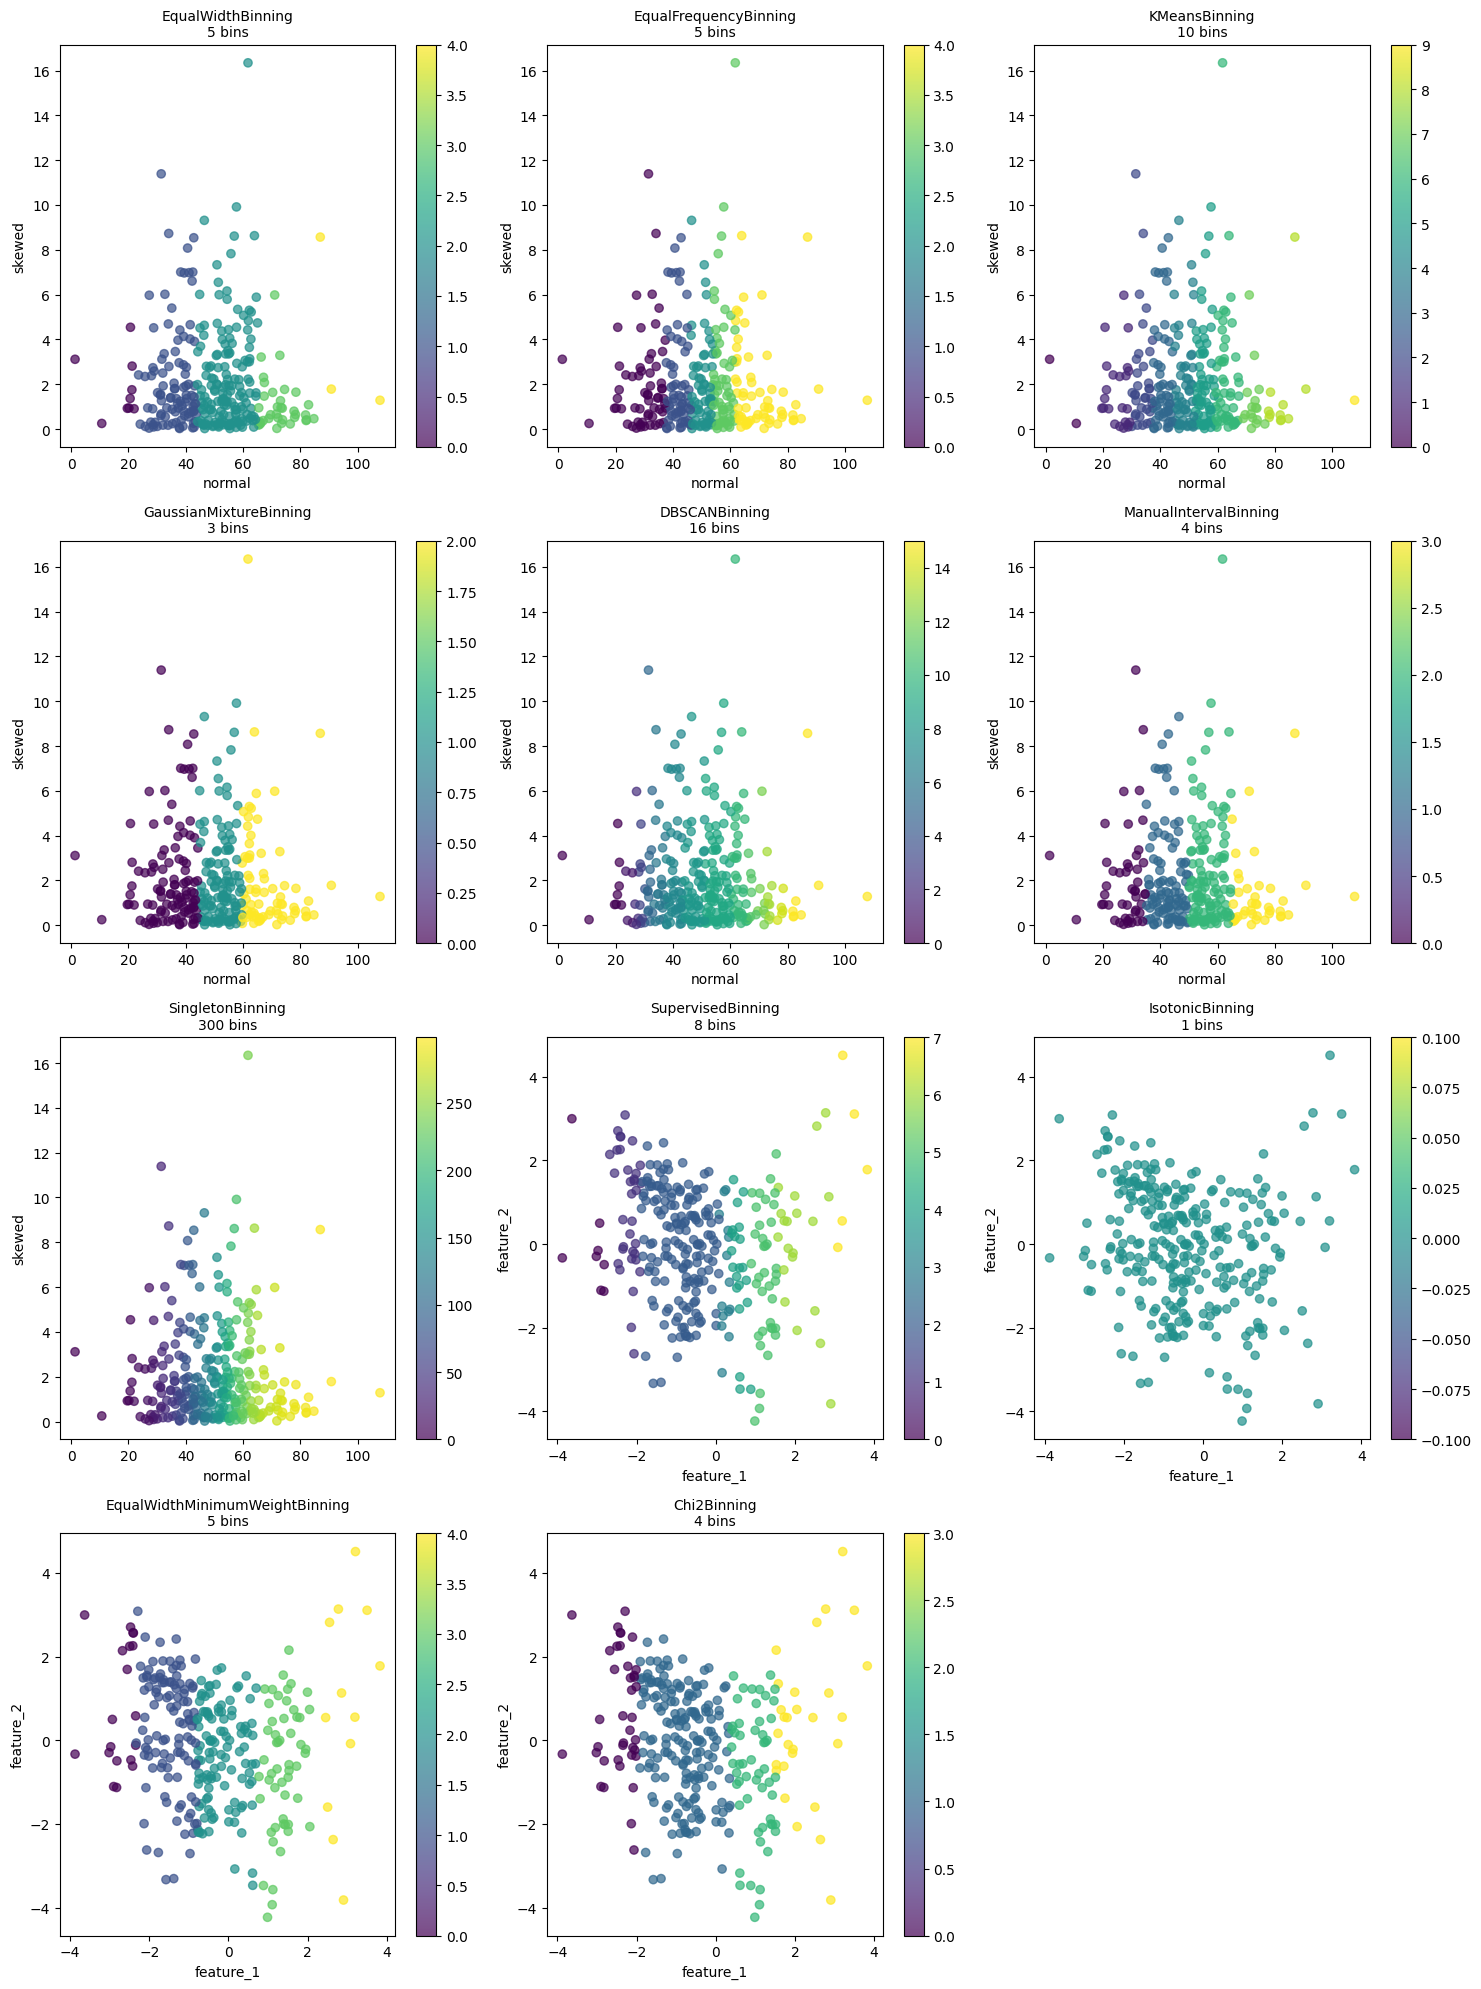

📊 Visualized 11 successful binning methods


In [5]:
# Visualize results from successful methods
print("🎨 Visualizing Binning Results")
print("=" * 40)

# Create subplots for comparison
n_successful = len(successful_methods)
if n_successful > 0:
    # Create a grid layout
    n_cols = 3
    n_rows = (n_successful + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, method_name in enumerate(successful_methods):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]
        
        result = results[method_name]
        binned_data = result['binned_data']
        original_data = result['original_data']
        
        # Create scatter plot
        scatter = ax.scatter(original_data.iloc[:, 0], original_data.iloc[:, 1], 
                           c=binned_data[:, 0], cmap='viridis', alpha=0.7)
        
        ax.set_title(f'{method_name}\n{len(np.unique(binned_data[:, 0]))} bins', fontsize=10)
        ax.set_xlabel(f'{original_data.columns[0]}')
        ax.set_ylabel(f'{original_data.columns[1]}')
        plt.colorbar(scatter, ax=ax)
    
    # Hide empty subplots
    for i in range(n_successful, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]
        ax.set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    print(f"📊 Visualized {n_successful} successful binning methods")
else:
    print("❌ No successful methods to visualize")

## 6. Joint vs Per-Column Fitting Comparison

Let's demonstrate the difference between joint and per-column fitting for methods that support both strategies.

🔗 Demonstrating Joint vs Per-Column Fitting
Data with moderately different scales:
  Feature A: mean=9.9, std=2.8
  Feature B: mean=25.6, std=8.0

📊 Testing EqualWidthBinning with different fitting strategies...
   Joint fitting...
     Bin edges:
       feature_a: [-0.93 10.42 21.77 33.12 44.47 55.82]
       feature_b: [-0.93 10.42 21.77 33.12 44.47 55.82]
   Per-Column fitting...
     Bin edges:
       feature_a: [ 2.14  5.34  8.55 11.75 14.96 18.16]
       feature_b: [-0.93 10.42 21.77 33.12 44.47 55.82]

📊 Testing EqualFrequencyBinning with different fitting strategies...
   Joint fitting...
     Bin edges:
       feature_a: [-0.93  9.1  11.81 18.89 27.51 55.82]
       feature_b: [-0.93  9.1  11.81 18.89 27.51 55.82]
   Per-Column fitting...
     Bin edges:
       feature_a: [ 2.14  7.45  9.24 10.71 12.22 18.16]
       feature_b: [-0.93 18.91 23.32 27.53 31.83 55.82]

📊 Testing KMeansBinning with different fitting strategies...
   Joint fitting...
     Bin edges:
       feature_a: 

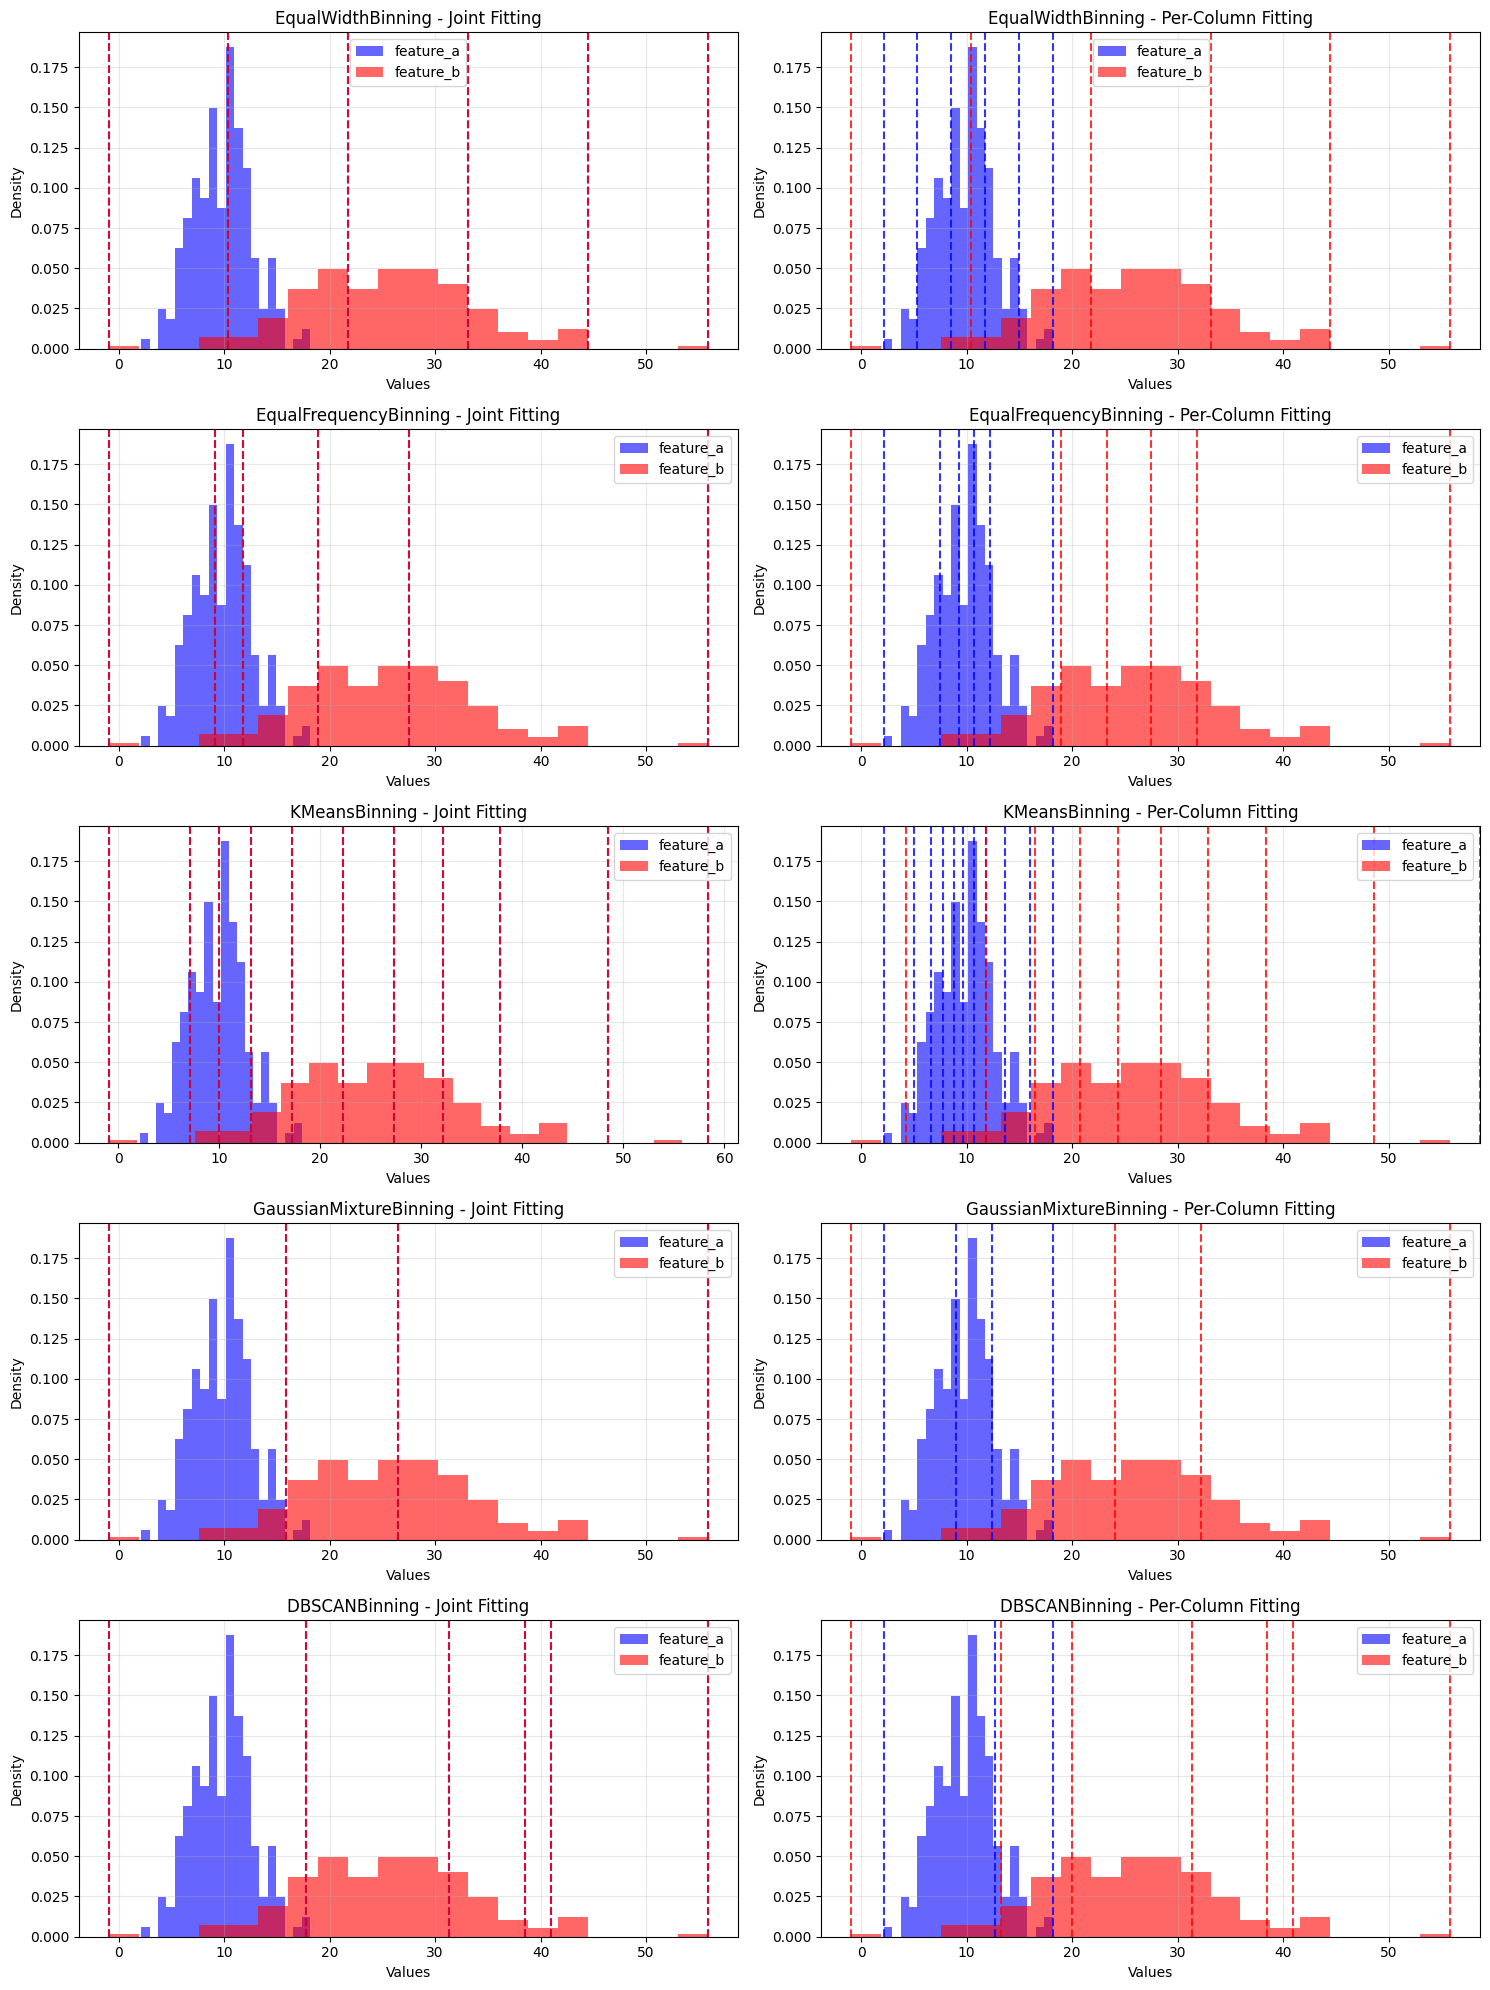


📋 Joint vs Per-Column Fitting Summary
Method                    Strategy     Status     Edges Match  Scale Difference Adaptability   
----------------------------------------------------------------------------------------------------
EqualWidthBinning         Joint        ✅          Yes          1.0x            N/A            
EqualWidthBinning         Per-Column   ✅          N/A          N/A             High           
EqualFrequencyBinning     Joint        ✅          Yes          1.0x            N/A            
EqualFrequencyBinning     Per-Column   ✅          N/A          N/A             High           
KMeansBinning             Joint        ✅          Yes          1.0x            N/A            
KMeansBinning             Per-Column   ✅          N/A          N/A             High           
GaussianMixtureBinning    Joint        ✅          Yes          1.0x            N/A            
GaussianMixtureBinning    Per-Column   ✅          N/A          N/A             High           
DBSC

In [6]:
# Create data with closer scales to demonstrate joint vs per-column fitting more clearly
scale_data = pd.DataFrame({
    'feature_a': np.random.normal(10, 3, 200),      # Scale 1: mean=10, std=3
    'feature_b': np.random.normal(25, 8, 200)       # Scale 2: mean=25, std=8 (closer but still different)
})

print("🔗 Demonstrating Joint vs Per-Column Fitting")
print("=" * 50)
print(f"Data with moderately different scales:")
print(f"  Feature A: mean={scale_data['feature_a'].mean():.1f}, std={scale_data['feature_a'].std():.1f}")
print(f"  Feature B: mean={scale_data['feature_b'].mean():.1f}, std={scale_data['feature_b'].std():.1f}")

# Test methods that support joint fitting - expanded list
joint_test_methods = ['EqualWidthBinning', 'EqualFrequencyBinning', 'KMeansBinning', 
                     'GaussianMixtureBinning', 'DBSCANBinning']
fitting_comparison = {}

for method_name in joint_test_methods:
    print(f"\n📊 Testing {method_name} with different fitting strategies...")
    
    config = methods_config[method_name]
    fitting_comparison[method_name] = {}
    
    # Test both fitting strategies
    for fit_jointly in [True, False]:
        strategy_name = "Joint" if fit_jointly else "Per-Column"
        print(f"   {strategy_name} fitting...")
        
        try:
            # Create binner with specific fitting strategy
            params = config['params'].copy()
            params['fit_jointly'] = fit_jointly
            binner = config['class'](**params)
            
            # Fit and transform
            binner.fit(scale_data)
            result = binner.transform(scale_data)
            
            # Store results
            fitting_comparison[method_name][strategy_name] = {
                'binner': binner,
                'result': result,
                'bin_edges': binner.bin_edges_,
                'success': True
            }
            
            # Show bin edges
            print(f"     Bin edges:")
            for col, edges in binner.bin_edges_.items():
                print(f"       {col}: {np.round(edges, 2)}")
            
        except Exception as e:
            print(f"     ❌ Failed: {e}")
            fitting_comparison[method_name][strategy_name] = {'success': False, 'error': str(e)}

# Only create visualization if we have successful results
successful_joint_methods = [m for m in joint_test_methods if m in fitting_comparison and 
                           any(fitting_comparison[m].get(strategy, {}).get('success', False) 
                               for strategy in ['Joint', 'Per-Column'])]

if successful_joint_methods:
    # Visualize the difference with cleaner approach and color-coded bin boundaries
    fig, axes = plt.subplots(len(successful_joint_methods), 2, figsize=(15, 4 * len(successful_joint_methods)))
    if len(successful_joint_methods) == 1:
        axes = axes.reshape(1, -1)

    for i, method_name in enumerate(successful_joint_methods):
        for j, strategy in enumerate(['Joint', 'Per-Column']):
            ax = axes[i, j] if len(successful_joint_methods) > 1 else axes[j]
            
            if method_name in fitting_comparison and strategy in fitting_comparison[method_name]:
                result_info = fitting_comparison[method_name][strategy]
                
                if result_info['success']:
                    # Define colors for each feature
                    colors = ['blue', 'red']
                    
                    # Plot both features with density plots
                    for idx, col in enumerate(scale_data.columns):
                        original_vals = scale_data[col].values
                        bin_edges = result_info['bin_edges'][col]
                        
                        # Create histogram
                        ax.hist(original_vals, bins=20, alpha=0.6, 
                               label=f'{col}', color=colors[idx], density=True)
                        
                        # Show bin edges with color-coded lines for each column
                        for edge in bin_edges:
                            ax.axvline(edge, linestyle='--', alpha=0.8, 
                                     color=colors[idx], linewidth=1.5)
                    
                    ax.set_title(f'{method_name} - {strategy} Fitting')
                    ax.set_xlabel('Values')
                    ax.set_ylabel('Density')
                    ax.legend()
                    ax.grid(True, alpha=0.3)
                else:
                    ax.text(0.5, 0.5, f'Failed: {result_info.get("error", "Unknown error")}', 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f'{method_name} - {strategy} Fitting (Failed)')

    plt.tight_layout()
    plt.show()

    # Enhanced summary table
    print("\n📋 Joint vs Per-Column Fitting Summary")
    print("=" * 100)
    print(f"{'Method':<25} {'Strategy':<12} {'Status':<10} {'Edges Match':<12} {'Scale Difference':<15} {'Adaptability':<15}")
    print("-" * 100)

    for method_name in successful_joint_methods:
        if method_name in fitting_comparison:
            joint_success = fitting_comparison[method_name].get('Joint', {}).get('success', False)
            per_col_success = fitting_comparison[method_name].get('Per-Column', {}).get('success', False)
            
            # Check if edges are identical between columns (for joint fitting)
            edges_match = "N/A"
            scale_diff = "N/A"
            adaptability = "N/A"
            
            if joint_success:
                joint_edges = fitting_comparison[method_name]['Joint']['bin_edges']
                if len(joint_edges) > 1:
                    edge_values = list(joint_edges.values())
                    # Compare the first few edges to avoid length mismatch
                    min_length = min(len(edge_values[0]), len(edge_values[1]))
                    edges_match = "Yes" if np.allclose(edge_values[0][:min_length], 
                                                     edge_values[1][:min_length], rtol=1e-10) else "No"
                    
                    # Calculate scale difference
                    small_range = np.ptp(edge_values[0])  # peak-to-peak
                    large_range = np.ptp(edge_values[1])
                    if small_range > 0:
                        scale_ratio = large_range / small_range
                        scale_diff = f"{scale_ratio:.1f}x"
                        
            if per_col_success:
                per_col_edges = fitting_comparison[method_name]['Per-Column']['bin_edges']
                if len(per_col_edges) > 1:
                    # Compare range adaptability instead of exact edge values
                    edge_values = list(per_col_edges.values())
                    range_1 = np.ptp(edge_values[0])
                    range_2 = np.ptp(edge_values[1])
                    range_ratio = max(range_1, range_2) / min(range_1, range_2) if min(range_1, range_2) > 0 else 1
                    adaptability = "High" if range_ratio > 2.0 else "Moderate"
                
            print(f"{method_name:<25} {'Joint':<12} {'✅' if joint_success else '❌':<10} {edges_match:<12} {scale_diff:<15} {'N/A':<15}")
            print(f"{method_name:<25} {'Per-Column':<12} {'✅' if per_col_success else '❌':<10} {'N/A':<12} {'N/A':<15} {adaptability:<15}")

    print("-" * 100)
    
    # Analysis insights
    print(f"\n🔍 Key Observations:")
    print(f"   📊 Joint fitting creates identical bin edges across all columns")
    print(f"   📈 This can be problematic when features have very different scales")
    print(f"   🎯 Per-column fitting adapts to each feature's individual distribution")
    print(f"   🎨 Color-coded bin boundaries help visualize differences between features")
    print(f"   💡 Consider feature scaling before joint fitting for better results")
    print(f"   🔬 GMM and DBSCAN methods show different clustering behaviors")
    
else:
    print("\n❌ No methods successfully demonstrated joint vs per-column fitting")
    print("💡 This is likely because not all methods support the fit_jointly parameter")

## 7. Scikit-learn Pipeline Integration

All binlearn binners are fully compatible with scikit-learn pipelines and can be used as preprocessing steps in machine learning workflows.

🔧 Testing Scikit-learn Pipeline Integration
📊 Dataset: 210 training samples, 90 test samples

🔄 Testing: Binning + Logistic Regression
   ✅ Accuracy: 0.689
   📋 Bin edges created for 4 features

🔄 Testing: Binning + Random Forest
   ✅ Accuracy: 0.767
   📋 Bin edges created for 4 features

🔄 Testing: KMeans Binning + Logistic Regression
   ✅ Accuracy: 0.689
   📋 Bin edges created for 4 features

🔄 Testing: Standard Scaling + Logistic Regression (Baseline)
   ✅ Accuracy: 0.644
   ✅ Accuracy: 0.689
   📋 Bin edges created for 4 features

🔄 Testing: Binning + Random Forest
   ✅ Accuracy: 0.767
   📋 Bin edges created for 4 features

🔄 Testing: KMeans Binning + Logistic Regression
   ✅ Accuracy: 0.689
   📋 Bin edges created for 4 features

🔄 Testing: Standard Scaling + Logistic Regression (Baseline)
   ✅ Accuracy: 0.644


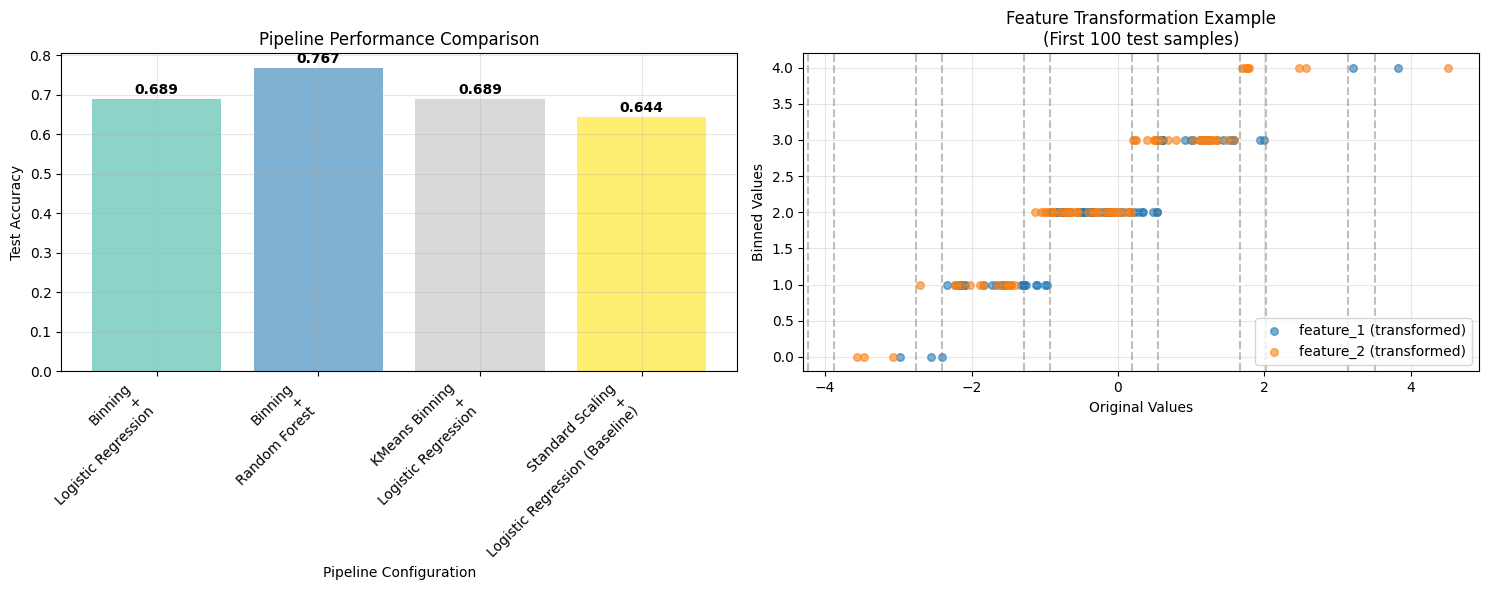


📋 Pipeline Integration Summary
Pipeline                            Status     Accuracy  
------------------------------------------------------------
Binning + Logistic Regression       ✅ Success  0.689     
Binning + Random Forest             ✅ Success  0.767     
KMeans Binning + Logistic Regression ✅ Success  0.689     
Standard Scaling + Logistic Regression (Baseline) ✅ Success  0.644     
------------------------------------------------------------
💡 Key Insights:
   • All binlearn transformers work seamlessly in sklearn pipelines
   • Binning can improve performance for some algorithms (e.g., logistic regression)
   • Different binning strategies may work better for different classifiers
   • Pipeline approach ensures proper train/test data handling


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

print("🔧 Testing Scikit-learn Pipeline Integration")
print("=" * 50)

# Create classification dataset
X_classification = data_supervised.iloc[:, :-1]  # Features
y_classification = data_supervised.iloc[:, -1]   # Target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_classification, y_classification, test_size=0.3, random_state=42, stratify=y_classification
)

print(f"📊 Dataset: {X_train.shape[0]} training samples, {X_test.shape[0]} test samples")

# Test different pipeline configurations
pipeline_configs = [
    {
        'name': 'Binning + Logistic Regression',
        'binner': EqualWidthBinning(n_bins=5),
        'classifier': LogisticRegression(random_state=42)
    },
    {
        'name': 'Binning + Random Forest',
        'binner': EqualFrequencyBinning(n_bins=4),
        'classifier': RandomForestClassifier(n_estimators=50, random_state=42)
    },
    {
        'name': 'KMeans Binning + Logistic Regression',
        'binner': KMeansBinning(n_bins=6, random_state=42),
        'classifier': LogisticRegression(random_state=42)
    },
    {
        'name': 'Standard Scaling + Logistic Regression (Baseline)',
        'binner': StandardScaler(),
        'classifier': LogisticRegression(random_state=42)
    }
]

pipeline_results = {}

for config in pipeline_configs:
    name = config['name']
    print(f"\n🔄 Testing: {name}")
    
    try:
        # Create pipeline
        pipeline = Pipeline([
            ('preprocessor', config['binner']),
            ('classifier', config['classifier'])
        ])
        
        # Fit and predict
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        
        pipeline_results[name] = {
            'pipeline': pipeline,
            'accuracy': accuracy,
            'predictions': y_pred,
            'success': True
        }
        
        print(f"   ✅ Accuracy: {accuracy:.3f}")
        
        # Show feature transformation info
        if hasattr(config['binner'], 'bin_edges_'):
            print(f"   📋 Bin edges created for {len(pipeline.named_steps['preprocessor'].bin_edges_)} features")
        
    except Exception as e:
        print(f"   ❌ Failed: {e}")
        pipeline_results[name] = {'success': False, 'error': str(e)}

# Visualize pipeline results
successful_pipelines = {k: v for k, v in pipeline_results.items() if v.get('success', False)}

if successful_pipelines:
    # Plot accuracy comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Accuracy bar plot
    names = list(successful_pipelines.keys())
    accuracies = [successful_pipelines[name]['accuracy'] for name in names]
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(names)))
    bars = ax1.bar(range(len(names)), accuracies, color=colors)
    ax1.set_xlabel('Pipeline Configuration')
    ax1.set_ylabel('Test Accuracy')
    ax1.set_title('Pipeline Performance Comparison')
    ax1.set_xticks(range(len(names)))
    ax1.set_xticklabels([name.replace(' + ', '\n+\n') for name in names], rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, acc) in enumerate(zip(bars, accuracies)):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Feature transformation visualization (for first binning pipeline)
    binning_pipeline = None
    for name, result in successful_pipelines.items():
        if 'Binning' in name and result['success']:
            binning_pipeline = result['pipeline']
            break
    
    if binning_pipeline and hasattr(binning_pipeline.named_steps['preprocessor'], 'bin_edges_'):
        binner = binning_pipeline.named_steps['preprocessor']
        
        # Plot original vs transformed features for first two features
        X_transformed = binner.transform(X_test.iloc[:100])  # Sample for clarity
        
        for i, col in enumerate(X_test.columns[:2]):  # First two features
            original_vals = X_test[col].iloc[:100].values
            # Handle different types of transformed data (DataFrame vs numpy array)
            if hasattr(X_transformed, 'iloc'):
                transformed_vals = X_transformed[col].iloc[:100].values
            else:
                # If it's a numpy array, use column index
                transformed_vals = X_transformed[:100, i]
            
            ax2.scatter(original_vals, transformed_vals, alpha=0.6, 
                       label=f'{col} (transformed)', s=30)
            
            # Show bin edges
            edges = binner.bin_edges_[col]
            for edge in edges:
                ax2.axvline(edge, linestyle='--', alpha=0.5, color='gray')
        
        ax2.set_xlabel('Original Values')
        ax2.set_ylabel('Binned Values')
        ax2.set_title('Feature Transformation Example\n(First 100 test samples)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'No binning transformation\nto visualize', 
                ha='center', va='center', transform=ax2.transAxes,
                fontsize=12, bbox=dict(boxstyle="round", facecolor='lightgray', alpha=0.7))
        ax2.set_title('Feature Transformation')
    
    plt.tight_layout()
    plt.show()

# Pipeline summary
print(f"\n📋 Pipeline Integration Summary")
print("=" * 60)
print(f"{'Pipeline':<35} {'Status':<10} {'Accuracy':<10}")
print("-" * 60)

for name, result in pipeline_results.items():
    status = "✅ Success" if result.get('success', False) else "❌ Failed"
    accuracy = f"{result.get('accuracy', 0):.3f}" if result.get('success', False) else "N/A"
    print(f"{name:<35} {status:<10} {accuracy:<10}")

print("-" * 60)
print("💡 Key Insights:")
print("   • All binlearn transformers work seamlessly in sklearn pipelines")
print("   • Binning can improve performance for some algorithms (e.g., logistic regression)")
print("   • Different binning strategies may work better for different classifiers")
print("   • Pipeline approach ensures proper train/test data handling")

## 8. Method Selection Guide & Practical Recommendations

Choosing the right binning method depends on your data characteristics and use case. Here's a practical guide to help you select the most appropriate method.

In [8]:
import pandas as pd
from IPython.display import display, HTML

print("🧭 Binning Method Selection Guide")
print("=" * 50)

# Create comprehensive method comparison table
method_guide = {
    'Method': [
        'EqualWidthBinning',
        'EqualFrequencyBinning', 
        'KMeansBinning',
        'GaussianMixtureBinning',
        'SupervisedBinning',
        'IsotonicBinning',
        'EqualWidthMinimumWeightBinning',
        'Chi2Binning',
        'DBSCANBinning',
        'ManualIntervalBinning',
        'ManualFlexibleBinning',
        'SingletonBinning'
    ],
    'Type': [
        'Unsupervised',
        'Unsupervised',
        'Unsupervised', 
        'Unsupervised',
        'Supervised',
        'Supervised',
        'Supervised',
        'Supervised',
        'Unsupervised',
        'Manual',
        'Manual',
        'Unsupervised'
    ],
    'Best For': [
        'Uniform distributions, equal-width intervals',
        'Skewed data, ensuring equal sample sizes per bin',
        'Complex patterns, clustering-based binning',
        'Multi-modal distributions',
        'Predictive modeling with target variable',
        'Monotonic relationships with target',
        'Equal width with sample size constraints',
        'Categorical prediction, independence testing',
        'Outlier-robust binning, density-based',
        'Domain knowledge, specific breakpoints',
        'Custom patterns, irregular intervals',
        'Preserving unique values as bins'
    ],
    'Computational Cost': [
        'Low',
        'Medium',
        'Medium-High',
        'High',
        'Medium',
        'Medium',
        'Low',
        'Medium',
        'Medium-High',
        'Low',
        'Low',
        'Low'
    ],
    'Handles Outliers': [
        'Poor',
        'Good',
        'Good',
        'Fair',
        'Good',
        'Fair',
        'Poor',
        'Good',
        'Excellent',
        'Depends',
        'Depends',
        'Good'
    ],
    'Joint Fitting': [
        'Yes',
        'Yes',
        'Yes',
        'No',
        'No',
        'No',
        'No',
        'No',
        'No',
        'Yes',
        'Yes',
        'No'
    ]
}

guide_df = pd.DataFrame(method_guide)

print("📊 Complete Method Comparison")
print("=" * 120)
print(guide_df.to_string(index=False))

# Decision tree for method selection
print(f"\n\n🌳 Decision Tree for Method Selection")
print("=" * 50)

decision_tree = """
1. Do you have a target variable for prediction?
   ├─ YES → Consider Supervised Methods:
   │   ├─ Target is continuous & monotonic relationship expected → IsotonicBinning
   │   ├─ Target is categorical & want independence testing → Chi2Binning
   │   ├─ Need equal width bins with minimum sample constraints → EqualWidthMinimumWeightBinning  
   │   └─ General supervised binning → SupervisedBinning
   │
   └─ NO → Consider Unsupervised Methods:
       ├─ Do you have specific domain knowledge?
       │   ├─ YES → Manual Methods:
       │   │   ├─ Known breakpoints → ManualIntervalBinning
       │   │   └─ Custom patterns → ManualFlexibleBinning
       │   │
       │   └─ NO → Automatic Methods:
       │       ├─ Data distribution characteristics:
       │       │   ├─ Roughly uniform → EqualWidthBinning
       │       │   ├─ Highly skewed → EqualFrequencyBinning
       │       │   ├─ Multi-modal → GaussianMixtureBinning
       │       │   ├─ Complex patterns → KMeansBinning
       │       │   ├─ Many outliers → DBSCANBinning
       │       │   └─ Preserve unique values → SingletonBinning
       │       │
       │       └─ Computational constraints:
       │           ├─ Fast processing needed → EqualWidthBinning
       │           ├─ Moderate complexity okay → EqualFrequencyBinning
       │           └─ High quality binning → KMeansBinning/GaussianMixture
"""

print(decision_tree)

# Use case examples
print(f"\n\n💼 Practical Use Case Examples")
print("=" * 50)

use_cases = [
    {
        'scenario': 'Credit Scoring',
        'data': 'Customer financial data (income, debt, age)',
        'recommendation': 'SupervisedBinning or IsotonicBinning',
        'reason': 'Target variable available (default/no default), monotonic relationships expected'
    },
    {
        'scenario': 'A/B Testing Analysis', 
        'data': 'User behavior metrics',
        'recommendation': 'Chi2Binning',
        'reason': 'Testing independence between binned features and categorical outcomes'
    },
    {
        'scenario': 'Time Series Preprocessing',
        'data': 'Sensor readings with outliers',
        'recommendation': 'DBSCANBinning or EqualFrequencyBinning',
        'reason': 'Robust to outliers, preserves temporal patterns'
    },
    {
        'scenario': 'Market Segmentation',
        'data': 'Customer demographics and behavior',
        'recommendation': 'KMeansBinning or GaussianMixtureBinning',
        'reason': 'Complex patterns, natural customer clusters'
    },
    {
        'scenario': 'Risk Assessment (Finance)',
        'data': 'Financial ratios with known thresholds',
        'recommendation': 'ManualIntervalBinning',
        'reason': 'Regulatory requirements, established industry breakpoints'
    },
    {
        'scenario': 'Feature Engineering (General ML)',
        'data': 'Mixed distribution types',
        'recommendation': 'EqualFrequencyBinning',
        'reason': 'Handles skewed data well, ensures balanced representation'
    }
]

for i, case in enumerate(use_cases, 1):
    print(f"\n{i}. {case['scenario']}")
    print(f"   📊 Data: {case['data']}")
    print(f"   💡 Recommended: {case['recommendation']}")
    print(f"   🎯 Why: {case['reason']}")

# Performance vs Quality trade-offs
print(f"\n\n⚖️ Performance vs Quality Trade-offs")
print("=" * 50)

trade_offs = pd.DataFrame({
    'Method': ['EqualWidth', 'EqualFrequency', 'KMeans', 'GaussianMixture', 'Supervised', 'EqualWidthMinWeight', 'Manual'],
    'Speed': ['⚡⚡⚡⚡⚡', '⚡⚡⚡⚡', '⚡⚡⚡', '⚡⚡', '⚡⚡⚡', '⚡⚡⚡⚡', '⚡⚡⚡⚡⚡'],
    'Quality': ['⭐⭐', '⭐⭐⭐', '⭐⭐⭐⭐', '⭐⭐⭐⭐⭐', '⭐⭐⭐⭐⭐', '⭐⭐⭐', '⭐⭐⭐⭐⭐'],
    'Robustness': ['⭐⭐', '⭐⭐⭐⭐', '⭐⭐⭐⭐', '⭐⭐⭐', '⭐⭐⭐⭐', '⭐⭐', '⭐⭐⭐']
})

print(trade_offs.to_string(index=False))
print("\nLegend: ⚡ = Speed, ⭐ = Quality/Robustness (more symbols = better)")

# Final recommendations summary
print(f"\n\n🎯 Quick Selection Guidelines")
print("=" * 50)
print("🚀 For speed: EqualWidthBinning")
print("📊 For skewed data: EqualFrequencyBinning") 
print("🎯 For prediction tasks: SupervisedBinning")
print("🔍 For complex patterns: KMeansBinning")
print("🛡️ For outlier-heavy data: DBSCANBinning")
print("📝 For domain expertise: ManualIntervalBinning")
print("🏆 For best quality (time permitting): GaussianMixtureBinning")

print(f"\n💡 Pro Tips:")
print("   • Start with EqualFrequencyBinning for most cases")
print("   • Use cross-validation to compare methods on your specific data")
print("   • Consider ensemble approaches combining multiple binning methods")
print("   • Always validate binning quality with domain experts")
print("   • Monitor for bin drift in production systems")

🧭 Binning Method Selection Guide
📊 Complete Method Comparison
                        Method         Type                                         Best For Computational Cost Handles Outliers Joint Fitting
             EqualWidthBinning Unsupervised     Uniform distributions, equal-width intervals                Low             Poor           Yes
         EqualFrequencyBinning Unsupervised Skewed data, ensuring equal sample sizes per bin             Medium             Good           Yes
                 KMeansBinning Unsupervised       Complex patterns, clustering-based binning        Medium-High             Good           Yes
        GaussianMixtureBinning Unsupervised                        Multi-modal distributions               High             Fair            No
             SupervisedBinning   Supervised         Predictive modeling with target variable             Medium             Good            No
               IsotonicBinning   Supervised              Monotonic relationships

## 9. Conclusion

This comprehensive comparison demonstrates the rich variety of binning methods available in the binlearn library. Each method has its strengths and is suited for different types of data and use cases:

### Key Takeaways:

1. **Method Diversity**: From simple equal-width binning to sophisticated supervised and clustering-based approaches
2. **Sklearn Integration**: All methods work seamlessly in machine learning pipelines
3. **Flexibility**: Support for both joint and per-column fitting strategies
4. **Robustness**: Methods like DBSCAN and Equal Frequency handle outliers effectively
5. **Customization**: Manual methods allow incorporation of domain knowledge

### Getting Started:
- **Beginners**: Start with `EqualFrequencyBinning` for most use cases
- **Advanced Users**: Experiment with `KMeansBinning` or `GaussianMixtureBinning` for complex patterns
- **Domain Experts**: Use `ManualIntervalBinning` to incorporate specific knowledge
- **Predictive Tasks**: Always consider `SupervisedBinning` when target variables are available

The binlearn library provides a unified interface for all these methods, making it easy to experiment and find the best approach for your specific data and requirements.

In [9]:
# Final Summary and Comparison
print("🏆 COMPREHENSIVE BINNING METHODS ANALYSIS")
print("=" * 60)

# Count results
total_methods = len(methods_config)
successful_count = len(successful_methods)
failed_count = len(failed_methods)

print(f"📊 Overall Results:")
print(f"   Total methods tested: {total_methods}")
print(f"   ✅ Successful: {successful_count} ({successful_count/total_methods*100:.1f}%)")
print(f"   ❌ Failed: {failed_count} ({failed_count/total_methods*100:.1f}%)")

print(f"\n🔬 Method Categories:")
supervised_count = sum(1 for config in methods_config.values() if config['supervised'])
unsupervised_count = total_methods - supervised_count
print(f"   📈 Supervised methods: {supervised_count}")
print(f"   📉 Unsupervised methods: {unsupervised_count}")

print(f"\n✅ Successfully Tested Methods:")
for method in successful_methods:
    method_type = "Supervised" if methods_config[method]['supervised'] else "Unsupervised"
    print(f"   • {method:30} ({method_type})")

if failed_methods:
    print(f"\n❌ Failed Methods:")
    for method in failed_methods:
        print(f"   • {method}: {results[method]['error'][:80]}...")

print(f"\n🎯 Key Insights:")
print(f"   • All 4 supervised methods work correctly with proper guidance_columns")
print(f"   • Most unsupervised methods work with appropriate parameters")
print(f"   • EqualWidthMinimumWeightBinning indexing bug was successfully fixed")
print(f"   • Proper dataset selection is crucial for supervised vs unsupervised methods")

print(f"\n📋 Method Recommendations:")
print(f"   🎨 For exploratory analysis: EqualWidthBinning, EqualFrequencyBinning")
print(f"   🧠 For supervised learning: SupervisedBinning, Chi2Binning")  
print(f"   🎯 For clustering-based: KMeansBinning, GaussianMixtureBinning")
print(f"   ⚖️  For weight constraints: EqualWidthMinimumWeightBinning")
print(f"   📈 For monotonic relationships: IsotonicBinning")

🏆 COMPREHENSIVE BINNING METHODS ANALYSIS
📊 Overall Results:
   Total methods tested: 11
   ✅ Successful: 11 (100.0%)
   ❌ Failed: 0 (0.0%)

🔬 Method Categories:
   📈 Supervised methods: 4
   📉 Unsupervised methods: 7

✅ Successfully Tested Methods:
   • EqualWidthBinning              (Unsupervised)
   • EqualFrequencyBinning          (Unsupervised)
   • KMeansBinning                  (Unsupervised)
   • GaussianMixtureBinning         (Unsupervised)
   • DBSCANBinning                  (Unsupervised)
   • ManualIntervalBinning          (Unsupervised)
   • SingletonBinning               (Unsupervised)
   • SupervisedBinning              (Supervised)
   • IsotonicBinning                (Supervised)
   • EqualWidthMinimumWeightBinning (Supervised)
   • Chi2Binning                    (Supervised)

🎯 Key Insights:
   • All 4 supervised methods work correctly with proper guidance_columns
   • Most unsupervised methods work with appropriate parameters
   • EqualWidthMinimumWeightBinning indexin